# Predicting Rossmann Store Sales

This notebook walks through the process of predicting daily sales for Rossmann stores. The solution involves several key stages:

1.  **Data Loading & Merging**: Combining the sales data with store-specific information.
2.  **Feature Engineering**: Creating new, insightful features from existing data, particularly from dates and promotional information.
3.  **Data Preprocessing**: Handling missing values, scaling numerical data, and encoding categorical variables.
4.  **Modeling with XGBoost**: Training a powerful gradient boosting model.
5.  **Evaluation & Tuning**: Using K-Fold cross-validation for robust evaluation and manually tuning hyperparameters to improve performance.
6.  **Submission**: Generating the final predictions for the competition.

Let's dive in!

In [2]:
# Import pandas for data manipulation and warnings to manage notifications
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading and Merging

We start by loading the three provided datasets:
* `train.csv`: Contains the daily sales data for each store. This is our primary training data.
* `store.csv`: Contains supplementary information about each store, such as store type, assortment, and competition details.
* `test.csv`: Contains the dates and stores for which we need to predict sales.

We'll merge the sales data with the store information to create a single, comprehensive DataFrame.

In [3]:
# Load the store information dataset
store_df = pd.read_csv('store.csv')
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
# Load the training dataset, which contains the historical sales data
raw_df = pd.read_csv('train.csv')
raw_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
# Merge the training data with the store information using a left merge on the 'Store' ID
merged_df = raw_df.merge(store_df, how='left', on='Store')
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [6]:
# Load the test dataset
test_df = pd.read_csv('test.csv')
# Merge the test data with the store information, just as we did with the training data
merged_test_df= test_df.merge(store_df, how='left', on='Store')
merged_test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


## 2. Feature Engineering

This is a critical step where we create new features that can help our model better understand the data. We'll engineer features related to dates, competition, and promotions.

### Date Features
We'll extract the year, month, day, and week of the year from the `Date` column. This allows the model to capture trends and seasonality.

In [7]:
# Define a function to extract date components from the 'Date' column
def split_date(df):
    # Convert 'Date' column to datetime objects
    df['Date'] = pd.to_datetime(df['Date'])
    # Extract year, month, day, and week of the year
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [8]:
# Apply the function to both the training and test DataFrames
split_date(merged_df)
split_date(merged_test_df)

### Data Cleaning: Handling Closed Stores
An important observation is that when a store is closed (`Open == 0`), its sales are always zero. Our model only needs to learn the patterns for open stores. We'll filter out the closed stores from our training data. For the final prediction, we'll manually set the sales for closed stores to zero.

In [9]:
# Check the sales values for rows where the store is closed
merged_df[merged_df.Open == 0].Sales.value_counts()
# As expected, when the store is closed, sales are always zero.

Sales
0    172817
Name: count, dtype: int64

In [10]:
# We will train our model only on the data where stores were open.
# We create a copy to avoid SettingWithCopyWarning.
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition Features
We'll calculate the number of months a competitor has been open. This can help the model understand the impact of competition on sales over time.

In [11]:
# Define a function to calculate the duration of competition in months
def comp_months(df):
    # Calculate the number of months since the competition opened
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    # If the competition opened in the future, set the duration to 0. Fill any NaNs with 0.
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [12]:
# Apply the competition feature engineering to both datasets
comp_months(merged_df)
comp_months(merged_test_df)

In [13]:
# Display the newly created 'CompetitionOpen' feature
merged_df.CompetitionOpen

0           82.0
1           92.0
2          103.0
3           70.0
4            3.0
           ...  
1016776     76.0
1016827    159.0
1016863      0.0
1017042      0.0
1017190    130.0
Name: CompetitionOpen, Length: 844392, dtype: float64

In [14]:
# Transpose the DataFrame to view all columns for a few rows
merged_df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a


### Promotion Features
We'll create features related to the continuous `Promo2` promotion. Specifically, we'll calculate:
1.  `Promo2Open`: The duration (in months) that `Promo2` has been active for a given store.
2.  `IsPromo2Month`: A binary flag indicating if the current month is part of the `Promo2` interval (e.g., "Jan,Apr,Jul,Oct").

In [15]:
# Helper function to check if the current month is a Promo2 month
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        # Get the list of promo months (e.g., ['Jan', 'Apr', ...])
        months = (row['PromoInterval'] or '').split(',')
        # Check if the store has Promo2 and if the current month is in the list
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

# Main function to create promotion-related columns
def promo_cols(df):
    # Calculate months since Promo2 was active
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    # Set to 0 if negative and fill NaNs. Only keep the value if Promo2 is active for the store.
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']

    # Check if the current month is a promotion month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [16]:
# Apply the promotion feature engineering to both datasets
promo_cols(merged_df)
promo_cols(merged_test_df)

In [17]:
# Display the DataFrame with all the new features
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,NaN,2015,7,31,31,3.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,76.0,0.000000,0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,159.0,0.000000,0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,...,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0,1.213115,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,0.0,0.000000,0


## 3. Data Preprocessing

Now we prepare the data for the model. This involves selecting our features, handling missing values, scaling numerical data, and encoding categorical variables.

In [18]:
# List all column names for reference
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [19]:
# Define the columns we will use as inputs (features) and the target variable
input_cols = ['Store', 'DayOfWeek', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day',
        'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [20]:
# Create the input and target DataFrames for the training set
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [21]:
# Create the input DataFrame for the test set
test_inputs = merged_test_df[input_cols].copy()

In [22]:
# Separate columns into numerical and categorical types
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']
numeric_cols = list(set(input_cols) - set(categorical_cols))

### Imputing Missing Values
We have missing values in `CompetitionDistance`. The assumption is that a missing value means there is no competition nearby. We'll fill these missing values with a very large number (twice the maximum observed distance) to represent this.

In [23]:
# Check for missing values in the numerical columns
inputs[numeric_cols].isna().sum()

CompetitionOpen           0
Year                      0
Day                       0
Promo2Open                0
Store                     0
Promo2                    0
Month                     0
IsPromo2Month             0
SchoolHoliday             0
WeekOfYear                0
Promo                     0
CompetitionDistance    2186
dtype: int64

In [24]:
# Get the maximum competition distance
max_dist = inputs.CompetitionDistance.max()
# Fill missing values with a value larger than any existing distance
inputs['CompetitionDistance'].fillna(max_dist*2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_dist*2, inplace=True)

### Scaling Numerical Features
We'll scale our numerical features to the range [0, 1]. This helps some machine learning algorithms perform better. While not strictly necessary for tree-based models like XGBoost, it's good practice.

In [25]:
# Import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [26]:
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler on the training data's numeric columns
scaler.fit(inputs[numeric_cols])

MinMaxScaler()

In [27]:
# Transform the numeric columns in both the training and test sets
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encoding Categorical Features
Machine learning models require numerical input. We'll convert our categorical columns (like `StoreType`) into numbers using **one-hot encoding**. This creates new binary (0/1) columns for each unique category.

In [28]:
# Import the OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

In [29]:
# Ensure categorical columns are of string type for the encoder
inputs[categorical_cols] = inputs[categorical_cols].astype(str)
test_inputs[categorical_cols] = test_inputs[categorical_cols].astype(str)

In [30]:
# Initialize the encoder. sparse=False returns a numpy array. handle_unknown='ignore' prevents errors on unseen test data categories.
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Fit the encoder on the training data's categorical columns
encoder.fit(inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [31]:
# Get the names of the new encoded columns
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [32]:
# Transform the categorical columns and add the new encoded columns to our DataFrames
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [33]:
# Create the final training and test sets with all processed features
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## 4. Modeling with XGBoost

We'll use the XGBoost library, which provides a high-performance implementation of gradient boosted decision trees.

In [34]:
# Import the XGBRegressor model
!pip install xgboost

from xgboost import XGBRegressor
# Initialize the model with some basic parameters
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [35]:
import xgboost as xgb
print(xgb.__version__)


2.1.3


In [36]:
from sklearn import set_config
set_config(display='text')


In [37]:
# Train the model on the entire training dataset
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [38]:
# Make predictions on the training data to see how well it fits
preds = model.predict(X)

### Evaluation Metric: RMSE
The competition uses the Root Mean Squared Percentage Error (RMSPE). For simplicity in training, we'll use the standard **Root Mean Squared Error (RMSE)**. Lower RMSE indicates a better fit.

In [39]:
# Import the mean_squared_error metric
from sklearn.metrics import mean_squared_error

# Define a function to calculate RMSE
def rmse(a, b):
    return mean_squared_error(a,b, squared=False)

In [40]:
import numpy as np

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))


In [41]:
# Calculate the RMSE on the training predictions
# Note: This is not a validation score and is likely overly optimistic.
rmse(preds, targets)

2357.1278101525777

### Feature Importance
Let's examine which features the model found most useful for making predictions.

In [42]:
# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'features': X.columns,
    'importance' : model.feature_importances_
}).sort_values('importance', ascending=False)

In [43]:
# Display the top 10 most important features
importance_df.head(10)

,features,importance
10,Promo,0.312826
12,DayOfWeek_1,0.077341
26,StoreType_d,0.072563
24,StoreType_b,0.067257
5,Promo2,0.040959
11,CompetitionDistance,0.040278
27,Assortment_a,0.038760
25,StoreType_c,0.037256
0,CompetitionOpen,0.032593
6,Month,0.027123


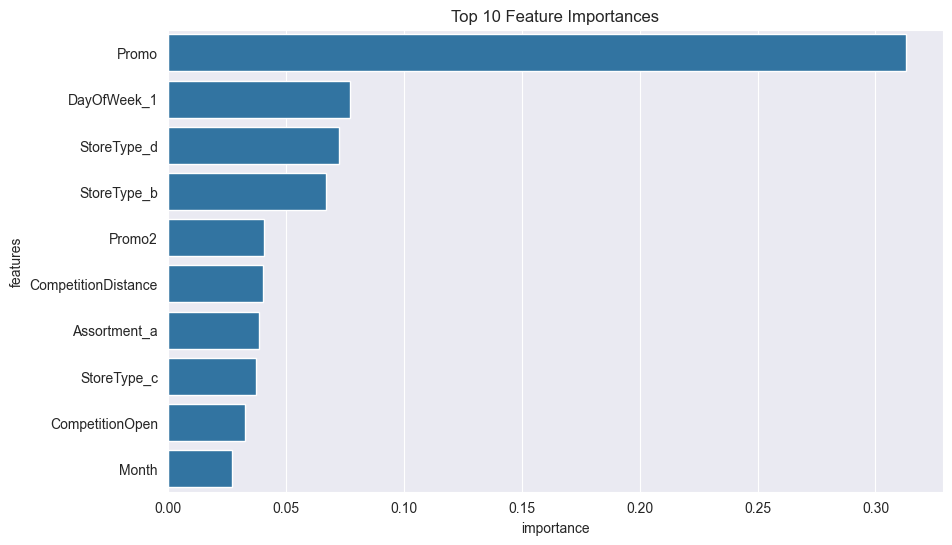

In [44]:
# Visualize the feature importances
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(10), x='importance', y='features')
plt.title('Top 10 Feature Importances')
plt.show()

## 5. K-Fold Cross-Validation
To get a more reliable estimate of our model's performance, we'll use **K-Fold Cross-Validation**. We split the data into 5 "folds", train a model on 4 folds, and evaluate on the 5th. We repeat this process 5 times, using each fold as the validation set once. The average validation score is a robust measure of how our model will perform on unseen data.

In [45]:
# Import KFold from scikit-learn
from sklearn.model_selection import KFold

In [46]:
# Define a function to train a model and return its train/validation RMSEs
def train_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [47]:
# Initialize 5-fold cross-validation
kfold = KFold(n_splits=5)

In [48]:
# Loop through the folds, train a model for each, and store them
models = []
for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]

    model, train_rmse, val_rmse = train_evaluate(X_train,
                                                 train_targets,
                                                 X_val,
                                                 val_targets,
                                                 max_depth=5,
                                                 n_estimators=20)

    models.append(model)
    print(f'TrainRMSE: {train_rmse:.4f}, ValRMSE: {val_rmse:.4f}')

TrainRMSE: 2243.1366, ValRMSE: 2331.3772
TrainRMSE: 2265.6084, ValRMSE: 2336.1829
TrainRMSE: 2214.6020, ValRMSE: 2209.9021
TrainRMSE: 2194.9140, ValRMSE: 2296.1195
TrainRMSE: 2230.5519, ValRMSE: 2341.1633


### Ensembling Predictions
We can often improve our results by averaging the predictions from all 5 models we trained during cross-validation. This technique is called **ensembling**.

In [49]:
# Define a function to average the predictions from a list of models
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [50]:
# Make predictions on the training set using the ensembled models
preds = predict_avg(models, X)
preds

array([7963.7515, 7316.5015, 8569.844 , ..., 7763.2695, 7248.8647,
       8374.333 ], dtype=float32)

## 6. Hyperparameter Tuning
We can further improve our model by tuning its hyperparameters. We'll manually test different values for key parameters like `n_estimators` (number of trees), `max_depth` (tree depth), and `learning_rate`.

In [51]:
# Create a simple train-validation split for quick hyperparameter testing
from sklearn.model_selection import train_test_split
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1, random_state=42)

In [52]:
# Define a function to quickly test different hyperparameters
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_rmse = rmse(train_pred, train_targets)
    val_rmse = rmse(val_pred, val_targets)
    print(f'Parameters: {params}')
    print(f'Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}\n')

In [53]:
# Tuning n_estimators
test_params(n_estimators=50)
test_params(n_estimators=120)
test_params(n_estimators=240)
test_params(n_estimators=300)

Parameters: {'n_estimators': 50}
Train RMSE: 1539.6793, Validation RMSE: 1550.2069

Parameters: {'n_estimators': 120}
Train RMSE: 1084.3914, Validation RMSE: 1099.3192

Parameters: {'n_estimators': 240}
Train RMSE: 898.4850, Validation RMSE: 918.1530

Parameters: {'n_estimators': 300}
Train RMSE: 851.1062, Validation RMSE: 873.1083



As we increase the number of estimators, the validation RMSE generally decreases, though it might start to overfit if we add too many.

In [54]:
# Tuning max_depth
test_params(max_depth=7)
test_params(max_depth=10)
test_params(max_depth=15)

Parameters: {'max_depth': 7}
Train RMSE: 992.9422, Validation RMSE: 1013.1603

Parameters: {'max_depth': 10}
Train RMSE: 661.1644, Validation RMSE: 760.7150

Parameters: {'max_depth': 15}
Train RMSE: 290.4906, Validation RMSE: 774.7592



A `max_depth` of 10 seems to provide a good balance. Deeper trees can lead to overfitting, increasing the validation RMSE.

### Model metrics in report

In [55]:
# Tuning learning_rate
test_params(n_estimators=50, learning_rate=0.5)
test_params(n_estimators=100, learning_rate=0.7)

Parameters: {'n_estimators': 50, 'learning_rate': 0.5}
Train RMSE: 1265.2063, Validation RMSE: 1278.2371

Parameters: {'n_estimators': 100, 'learning_rate': 0.7}
Train RMSE: 952.1816, Validation RMSE: 972.2169



## 7. Final Model and Submission

After experimenting with hyperparameters, we'll train a final model on the **entire training dataset** using a good combination of parameters. Then, we'll use this model to predict sales on the test set and create our submission file.

In [56]:
# Initialize the final model with tuned hyperparameters
# Note: These parameters are a starting point and can be further optimized.
model = XGBRegressor(n_jobs=-1,
                     random_state=42,
                     n_estimators=1000,
                     learning_rate=0.2,
                     max_depth=10,
                     subsample=0.9,
                     colsample_bytree=0.7)

In [57]:
# Train the final model on all available training data
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [58]:
# Make predictions on the test data
test_preds = model.predict(X_test)
test_preds

array([ 4679.0635,  8116.5444,  8940.276 , ...,  6893.6035, 24835.705 ,
        7195.6904], dtype=float32)

In [59]:
import pickle

# Save everything required for inference
artifacts = {
    "model": model,
    "scaler": scaler,
    "encoder": encoder,
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "encoded_cols": encoded_cols,
    "final_cols": list(X.columns)  # order the model expects
}

with open("sales_artifacts.pkl", "wb") as f:
    pickle.dump(artifacts, f)

print("Saved sales_artifacts.pkl")


Saved sales_artifacts.pkl


In [60]:
import pickle

with open("preprocess.pkl", "wb") as f:
    pickle.dump({
        "scaler": scaler,
        "encoder": encoder,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols,
        "encoded_cols": encoded_cols,
        "input_cols": input_cols
    }, f)


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, targets, test_size=0.1, random_state=42
)


In [63]:
model_val = XGBRegressor(
    n_jobs=-1,
    random_state=42,
    n_estimators=1000,
    learning_rate=0.2,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.7
)

model_val.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [64]:
y_pred = model_val.predict(X_val)


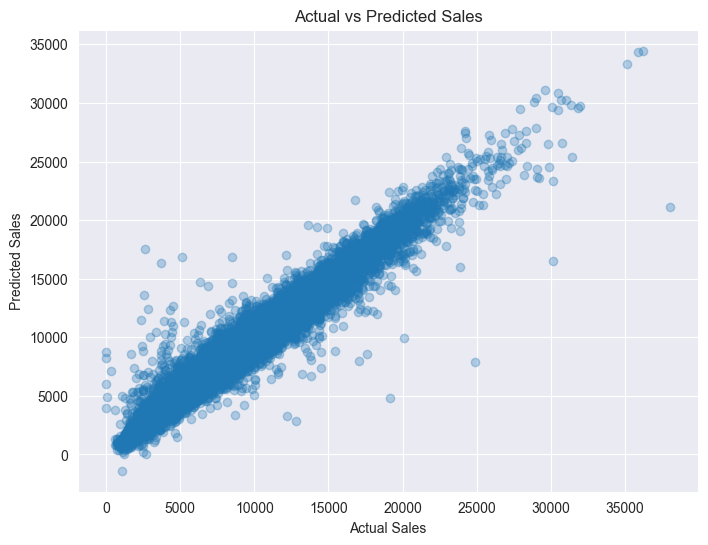

In [65]:
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.show()
